# РГР: Система оцінки ризику та прибутковості інвестицій _(нечітка логіка)_

ФІ-21 Мелоян Мирослав  

## 1. Налаштування середовища та імпорти

In [1]:
!pip install --quiet yfinance scikit-fuzzy scipy

In [2]:
import yfinance as yf
import time, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import skfuzzy as fuzz
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import zscore, spearmanr
from scipy.optimize import differential_evolution
from functools import partial
import ipywidgets as wd
import plotly.graph_objects as go
import itertools


plt.style.use("seaborn-v0_8")
%matplotlib inline

## 2. Завантаження даних і початкова обробка

In [3]:
tickers = [
    "AAPL", "MSFT", "AMZN", "GOOGL", "META", "NVDA", "TSLA", "JPM", "JNJ", "UNH",
    "V", "MA", "HD", "KO", "PEP", "PG", "DIS", "INTC", "CSCO", "BAC",
    "ADBE", "CRM", "ORCL", "WMT", "PFE", "T", "XOM", "CVX", "NKE", "MCD"
]
print(f"Total tickers: {len(tickers)}")

Total tickers: 30


In [4]:
# беремо щомісячні дані з 1 січня 2020 р.
data = yf.download(
    tickers,
    start="2020-01-01",
    interval="1mo",
    auto_adjust=False,
    progress=False
)["Adj Close"]

# місячна дохідність
monthly_ret = data.pct_change().dropna()

# середня дохідність і стандартне відхилення (ризик)
mean_ret = monthly_ret.mean()
std_ret  = monthly_ret.std(ddof=0)

# орієнтир: Sharpe Ratio, обрізаний до [-1; 1], потім нормований у [0;1]
sharpe_raw = mean_ret / std_ret.replace(0, np.nan)
sharpe_norm = ((sharpe_raw.clip(-1, 1) + 1) / 2).fillna(0)

# зведений DataFrame
df = pd.DataFrame({
    "Return": mean_ret,
    "Risk":   std_ret,
    "Sharpe": sharpe_norm
})
df.index.name = "Ticker"
df.head()

,Return,Risk,Sharpe
Ticker,,,
AAPL,0.018816,0.082011,0.614718
ADBE,0.007858,0.101862,0.538570
AMZN,0.015970,0.093836,0.585095
BAC,0.011161,0.090905,0.561388
CRM,0.011884,0.107378,0.555335


In [5]:
csv_path = "invest_data.csv"
df.to_csv(csv_path)
print(f"файл збережено → {csv_path}")

файл збережено → invest_data.csv


## 3. Первинний EDA (гістограми, тренд, викиди)

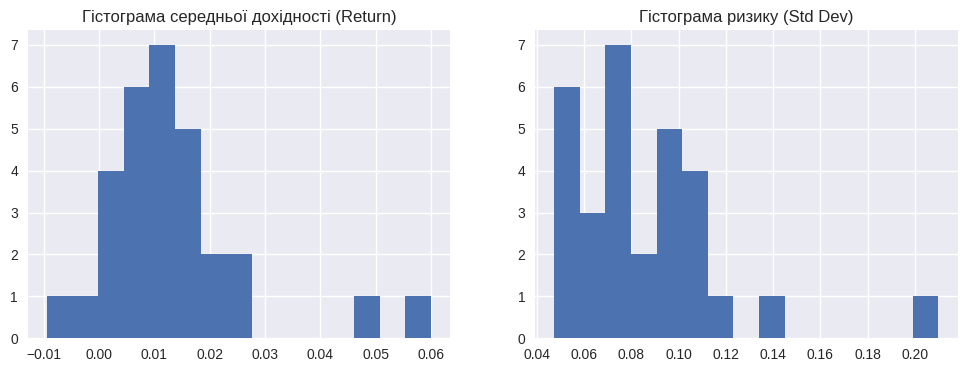

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df["Return"], bins=15)
axes[0].set_title("Гістограма середньої дохідності (Return)")
axes[1].hist(df["Risk"],   bins=15)
axes[1].set_title("Гістограма ризику (Std Dev)")
plt.show()

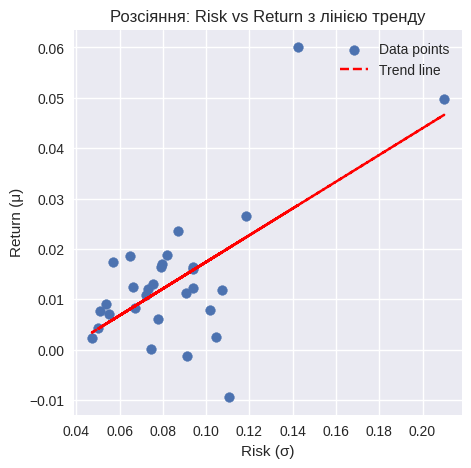

In [7]:
x = df["Risk"]
y = df["Return"]

coefficients = np.polyfit(x, y, 1)
trendline = np.poly1d(coefficients)

plt.figure(figsize=(5, 5))
plt.scatter(x, y, label="Data points")
plt.plot(x, trendline(x), color="red", linestyle="--", label="Trend line")
plt.xlabel("Risk (σ)")
plt.ylabel("Return (μ)")
plt.title("Розсіяння: Risk vs Return з лінією тренду")
plt.grid(True)
plt.legend()
plt.show()

In [8]:
z_scores = np.abs(zscore(df[["Return", "Risk"]], nan_policy="omit"))
outlier_mask = (z_scores > 3).any(axis=1)
outliers = df[outlier_mask]

print(f"виявлено потенційних викидів: {outliers.shape[0]}")
display(outliers)

df_clean = df[~outlier_mask].copy()

виявлено потенційних викидів: 2


,Return,Risk,Sharpe
Ticker,,,
NVDA,0.060050,0.142544,0.710636
TSLA,0.049845,0.209999,0.618678


In [9]:
summary = df.describe().T[["mean", "std", "min", "max"]]
summary.rename(columns={"mean": "Mean", "std": "Std"}, inplace=True)
summary

,Mean,Std,min,max
Return,0.013617,0.013583,-0.009459,0.060050
Risk,0.085762,0.032340,0.047221,0.209999
Sharpe,0.575998,0.051650,0.457202,0.710636


## 4. Визначення універсумів та трикутних MF

In [10]:
# безпечний діапазон (трішки розширимо межі, щоб MF "виходили" назовні)
pad_ret  = (df["Return"].max() - df["Return"].min()) * 0.05
pad_risk = (df["Risk"].max()   - df["Risk"].min())   * 0.05

x_ret  = np.linspace(df["Return"].min() - pad_ret,  df["Return"].max() + pad_ret,  100)
x_risk = np.linspace(df["Risk"].min()   - pad_risk, df["Risk"].max()   + pad_risk, 100)
x_scr  = np.linspace(0, 1, 100)   # універсум для виходу (score ∈ [0;1])

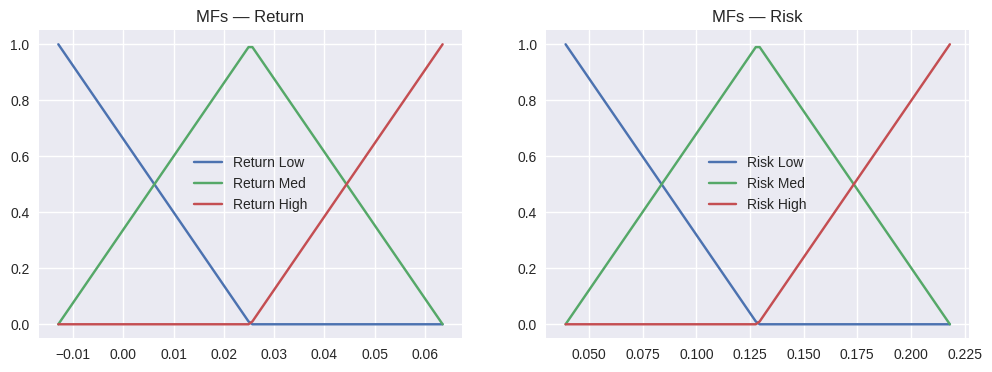

In [11]:
# 3-кутні параметри для return та risk
mid_ret  = (df["Return"].min() + df["Return"].max()) / 2
mid_risk = (df["Risk"].min()   + df["Risk"].max())   / 2

ret_params  = [(x_ret.min(),  x_ret.min(),  mid_ret),      # low
               (x_ret.min(),  mid_ret,      x_ret.max()),  # med
               (mid_ret,      x_ret.max(),  x_ret.max())]  # high

risk_params = [(x_risk.min(), x_risk.min(), mid_risk),     # low-risk
               (x_risk.min(), mid_risk,     x_risk.max()), # med-risk
               (mid_risk,     x_risk.max(), x_risk.max())] # high-risk

scr_params  = [(0.0, 0.0, 0.5),   # low score
               (0.0, 0.5, 1.0),   # medium score
               (0.5, 1.0, 1.0)]   # high score

# створюємо MF
ret_lo,  ret_md,  ret_hi  = (fuzz.trimf(x_ret,  p) for p in ret_params)
risk_lo, risk_md, risk_hi = (fuzz.trimf(x_risk, p) for p in risk_params)
scr_lo,  scr_md,  scr_hi  = (fuzz.trimf(x_scr,  p) for p in scr_params)

# візуалізація MF
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(x_ret,  ret_lo, label="Return Low")
ax[0].plot(x_ret,  ret_md, label="Return Med")
ax[0].plot(x_ret,  ret_hi, label="Return High")
ax[0].set_title("MFs — Return"); ax[0].legend()

ax[1].plot(x_risk, risk_lo, label="Risk Low")
ax[1].plot(x_risk, risk_md, label="Risk Med")
ax[1].plot(x_risk, risk_hi, label="Risk High")
ax[1].set_title("MFs — Risk");  ax[1].legend()
plt.show()

## 5. Ручна FIS (2 входи) та візуалізації

In [12]:
# індекси: 0 = low score, 1 = medium score, 2 = high score
#           risk  low   med   high
rule_table = np.array([[2,    1,    0],     # return High
                       [1,    1,    0],     # return Med
                       [1,    0,    0]])    # return Low
# порядок return: hi, med, low (як у масиві вище)
ret_mfs  = [ret_hi, ret_md, ret_lo]   # high, med, low
risk_mfs = [risk_lo, risk_md, risk_hi]# low, med, high
scr_mfs  = [scr_lo, scr_md, scr_hi]

In [13]:
def manual_fis(ret_val: float, risk_val: float) -> float:

    # фазифікація
    mu_ret  = [fuzz.interp_membership(x_ret,  mf, ret_val)  for mf in ret_mfs]
    mu_risk = [fuzz.interp_membership(x_risk, mf, risk_val) for mf in risk_mfs]

    # aгрегація правил (min для AND, max для OR)
    agg = np.zeros_like(x_scr)
    for i, mu_r in enumerate(mu_ret):          # return level
        for j, mu_k in enumerate(mu_risk):     # risk   level
            activation = min(mu_r, mu_k)
            if activation == 0:
                continue
            consequent_idx = rule_table[i, j]
            consequent_mf  = scr_mfs[consequent_idx]
            # implication: min(activation, MF)
            agg = np.fmax(agg, np.fmin(activation, consequent_mf))

    # дефазифікація
    if agg.max() == 0:
        return 0.5   # «байдужа» оцінка, якщо нічого не спрацювало
    return fuzz.defuzz(x_scr, agg, "centroid")

In [14]:
df["Score_manual"] = df.apply(lambda row: manual_fis(row.Return, row.Risk), axis=1)

mse  = mean_squared_error(df["Sharpe"], df["Score_manual"])
rmse = np.sqrt(mse)

print(f"MAE  = {mean_absolute_error(df['Sharpe'], df['Score_manual']):.4f}")
print(f"RMSE = {rmse:.4f}")

MAE  = 0.1108
RMSE = 0.1241


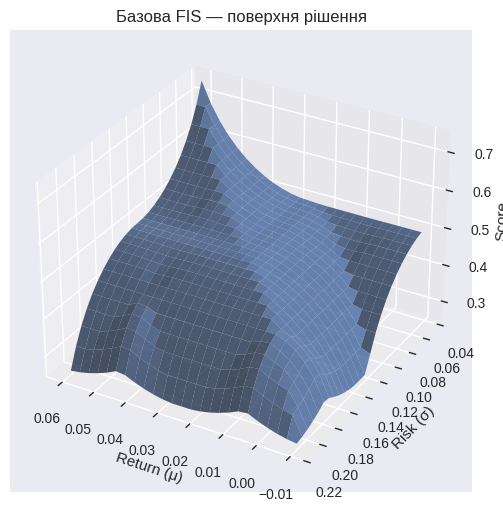

In [15]:
X, Y = np.meshgrid(
    np.linspace(df["Return"].min(), df["Return"].max(), 25),
    np.linspace(df["Risk"].min(),   df["Risk"].max(),   25)
)
Z = np.vectorize(manual_fis)(X, Y)

fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=True, alpha=0.8)
ax.set_xlabel("Return (μ)")
ax.set_ylabel("Risk (σ)")
ax.set_zlabel("Score")
ax.set_title("Базова FIS — поверхня рішення")
ax.view_init(elev=30, azim=120)
plt.show()

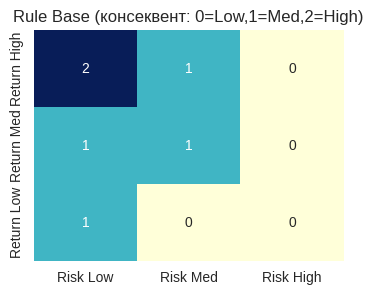

In [16]:
heatmap_df = pd.DataFrame(rule_table,
                          index=["Return High", "Return Med", "Return Low"],
                          columns=["Risk Low", "Risk Med", "Risk High"])
plt.figure(figsize=(4,3))
sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", cbar=False, fmt="d")
plt.title("Rule Base (консеквент: 0=Low,1=Med,2=High)")
plt.show()

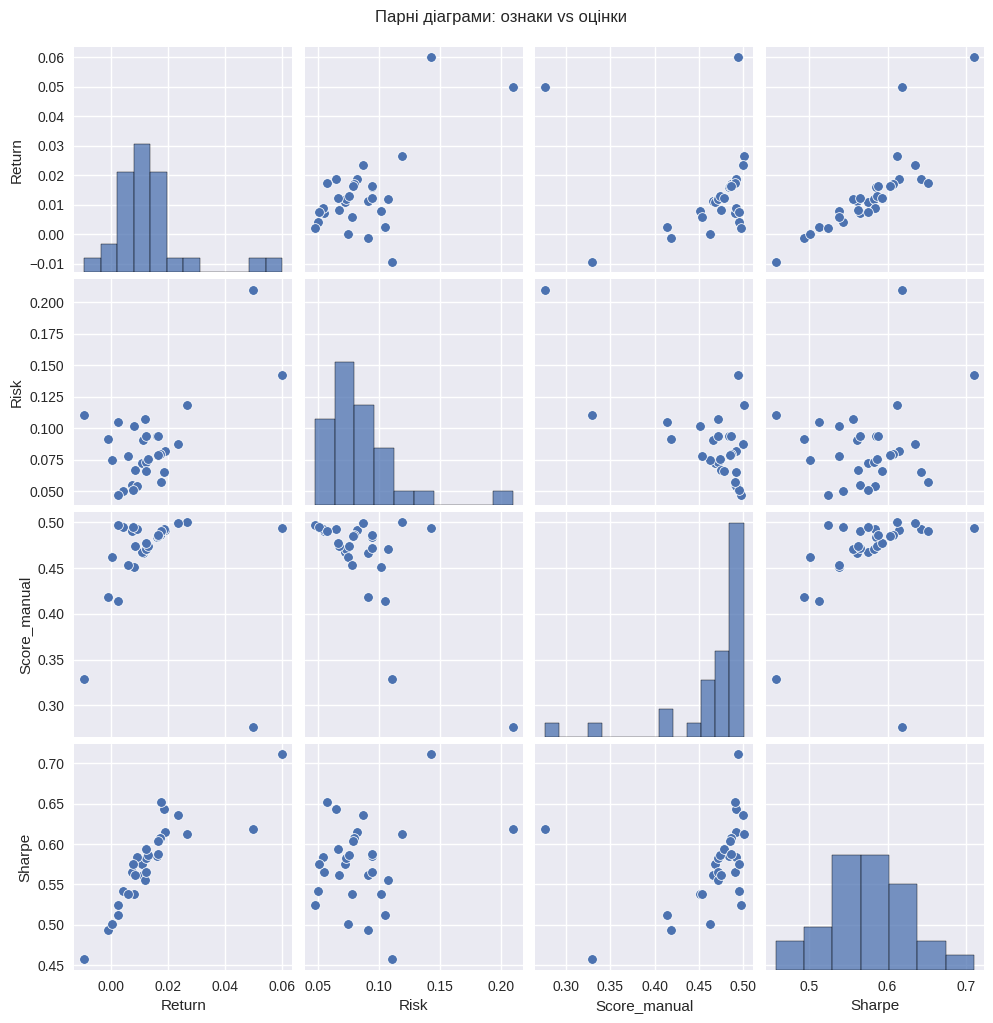

In [17]:
sns.pairplot(df[["Return", "Risk", "Score_manual", "Sharpe"]], diag_kind="hist")
plt.suptitle("Парні діаграми: ознаки vs оцінки", y=1.02)
plt.show()

## 6. Оптимізація 2-вхідної FIS за DE

In [18]:
# мін/макс для ознак
RET_MIN, RET_MAX   = df["Return"].min(), df["Return"].max()
RISK_MIN, RISK_MAX = df["Risk"].min(),   df["Risk"].max()

bounds = np.array(
    [(RET_MIN, RET_MAX)] * 3 +      # r1, r2, r3
    [(RISK_MIN, RISK_MAX)] * 3      # k1, k2, k3
)                                   # shape (6, 2)

# параметри DE
POP_SIZE   = 15        # кількість особин
MAX_ITER   = 300       # поколінь
F          = 0.5       # масштабний коефіцієнт мутації
CR         = 0.7       # імовірність кросоверу
SEED       = 42

rng = np.random.default_rng(SEED)

In [19]:
def make_triangles(points, x, x_min, x_max):
    p1, p2, p3 = points
    low  = fuzz.trimf(x, [x_min, p1, p2])
    med  = fuzz.trimf(x, [p1,   p2, p3])
    high = fuzz.trimf(x, [p2,   p3, x_max])
    return [low, med, high]

def compute_score(chrom, ret_series, risk_series):
    # сортуємо break-points (умова r1<r2<r3, k1<k2<k3)
    r_points  = np.sort(chrom[:3])
    k_points  = np.sort(chrom[3:])
    # генеруємо MF
    ret_mfs  = make_triangles(r_points,  x_ret,  RET_MIN, RET_MAX)
    risk_mfs = make_triangles(k_points,  x_risk, RISK_MIN, RISK_MAX)
    scr_mfs  = [scr_lo, scr_md, scr_hi]

    # інтерполяція → таблиці μ
    mu_ret  = np.vstack([fuzz.interp_membership(x_ret,  mf, ret_series)  for mf in ret_mfs]).T
    mu_risk = np.vstack([fuzz.interp_membership(x_risk, mf, risk_series) for mf in risk_mfs]).T

    scores = np.zeros(len(ret_series))
    for idx in range(scores.size):
        agg = np.zeros_like(x_scr)
        for i, μ_r in enumerate(mu_ret[idx]):
            for j, μ_k in enumerate(mu_risk[idx]):
                act = min(μ_r, μ_k)
                if act == 0: continue
                cons = scr_mfs[rule_table[i, j]]
                agg  = np.fmax(agg, np.fmin(act, cons))
        scores[idx] = fuzz.defuzz(x_scr, agg, "centroid") if agg.max() else 0.5
    return scores

In [20]:
def fitness(chrom):
    sc = compute_score(chrom, df["Return"].values, df["Risk"].values)
    mse = mean_squared_error(df["Sharpe"].values, sc)
    rmse = np.sqrt(mse)
    return rmse

In [21]:
history = []
def cb(xk, convergence):
    history.append(fitness(xk))   # поточне найкраще значення

result = differential_evolution(
    fitness,
    bounds,
    maxiter=300,
    popsize=15,
    seed=42,
    polish=False,
    updating="deferred",
    callback=cb,
    workers=1
)
best_chrom = result.x
print("Success:", result.success, "| Message:", result.message)
print("Best RMSE:", result.fun)

Success: True | Message: Optimization terminated successfully.
Best RMSE: 0.09709900436771016


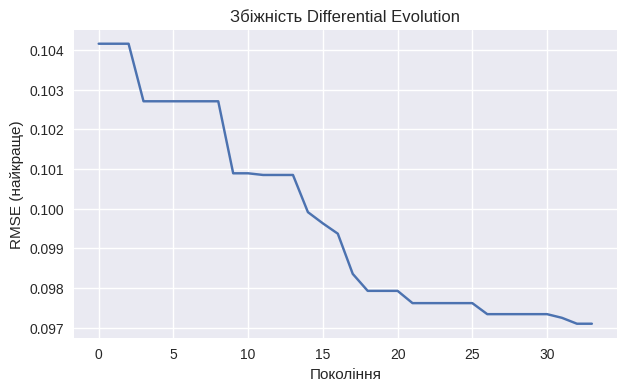

In [22]:
plt.figure(figsize=(7,4))
plt.plot(history)
plt.xlabel("Покоління"); plt.ylabel("RMSE (найкраще)")
plt.title("Збіжність Differential Evolution")
plt.grid(True); plt.show()

In [23]:
df["Score_opt"] = compute_score(best_chrom, df["Return"].values, df["Risk"].values)

mse_opt  = mean_squared_error(df["Sharpe"], df["Score_opt"])
opt_rmse = np.sqrt(mse_opt)

opt_mae  = mean_absolute_error(df["Sharpe"], df["Score_opt"])

print(f"Оптимізована MAE  = {opt_mae:.4f}")
print(f"Оптимізована RMSE = {opt_rmse:.4f}")

Оптимізована MAE  = 0.0644
Оптимізована RMSE = 0.0971


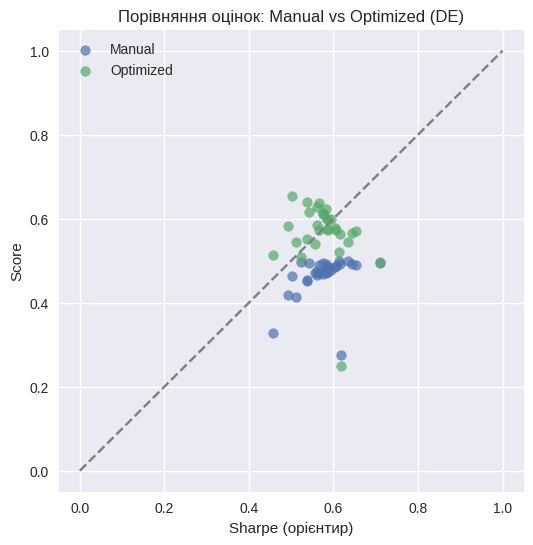

In [24]:
plt.figure(figsize=(6,6))
plt.scatter(df["Sharpe"], df["Score_manual"], label="Manual", alpha=0.7)
plt.scatter(df["Sharpe"], df["Score_opt"],    label="Optimized", alpha=0.7)
plt.plot([0,1],[0,1], "--", color="grey")
plt.xlabel("Sharpe (орієнтир)"); plt.ylabel("Score")
plt.title("Порівняння оцінок: Manual vs Optimized (DE)")
plt.legend(); plt.grid(True); plt.show()

In [25]:
mae_manual  = mean_absolute_error(df["Sharpe"], df["Score_manual"])
mse_manual  = mean_squared_error(df["Sharpe"], df["Score_manual"])
rmse_manual = np.sqrt(mse_manual)
rho_manual, _  = spearmanr(df["Sharpe"], df["Score_manual"])

mae_opt  = mean_absolute_error(df["Sharpe"], df["Score_opt"])
mse_opt  = mean_squared_error(df["Sharpe"], df["Score_opt"])
rmse_opt = np.sqrt(mse_opt)
rho_opt, _    = spearmanr(df["Sharpe"], df["Score_opt"])

metrics = pd.DataFrame({
    "MAE":   [mae_manual, mae_opt],
    "RMSE":  [rmse_manual,  rmse_opt],
    "ρ":     [rho_manual,   rho_opt]
}, index=["Manual FIS", "Optimized FIS"])
metrics.style.format("{:.4f}")

,MAE,RMSE,ρ
Manual FIS,0.1108,0.1241,0.5199
Optimized FIS,0.0644,0.0971,-0.3006


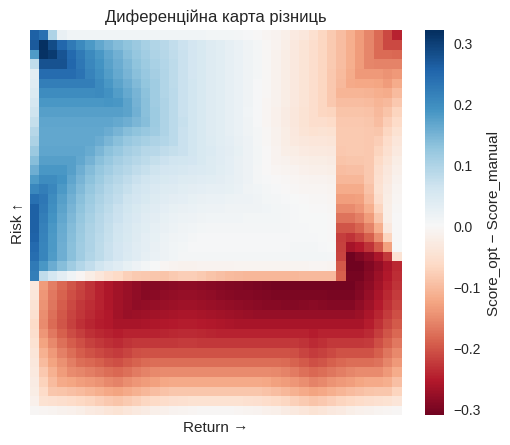

In [26]:
grid_size = 40
Xg, Yg = np.meshgrid(
    np.linspace(RET_MIN,  RET_MAX,  grid_size),
    np.linspace(RISK_MIN, RISK_MAX, grid_size)
)
Z_manual = np.vectorize(manual_fis)(Xg, Yg)
Z_opt    = compute_score(best_chrom, Xg.ravel(), Yg.ravel()).reshape(grid_size, grid_size)
Z_diff   = Z_opt - Z_manual

plt.figure(figsize=(6,5))
sns.heatmap(Z_diff, cmap="RdBu", center=0,
            xticklabels=False, yticklabels=False,
            cbar_kws={"label": "Score_opt − Score_manual"})
plt.title("Диференційна карта різниць")
plt.xlabel("Return →"); plt.ylabel("Risk ↑")
plt.show()

In [27]:
ret_slider  = wd.FloatSlider(value=float(df["Return"].median()),
                             min=float(RET_MIN), max=float(RET_MAX),
                             step=float((RET_MAX-RET_MIN)/200), description="Return")
risk_slider = wd.FloatSlider(value=float(df["Risk"].median()),
                             min=float(RISK_MIN), max=float(RISK_MAX),
                             step=float((RISK_MAX-RISK_MIN)/200), description="Risk")

@wd.interact(ret=ret_slider, risk=risk_slider)
def demo(ret, risk):
    manual_val = manual_fis(ret, risk)
    opt_val    = compute_score(best_chrom, np.array([ret]), np.array([risk]))[0]
    print(f"Manual Score   : {manual_val:.3f}")
    print(f"Optimized Score: {opt_val:.3f}")

interactive(children=(FloatSlider(value=0.011975698426998548, description='Return', max=0.060050090849455194, …

## 7. Розширення: обчислення β і побудова MF для трьох змінних

In [28]:
df = pd.read_csv("invest_data.csv", index_col="Ticker")

# 2) звантажуємо S&P-500 (^GSPC) та вирівнюємо дати
mkt_prices   = yf.download("^GSPC",
                           start="2020-01-01",
                           interval="1mo",
                           auto_adjust=False,
                           progress=False)["Adj Close"]
mkt_ret_full = mkt_prices.pct_change().dropna()
common_idx   = monthly_ret.index.intersection(mkt_ret_full.index)

ret_aligned  = monthly_ret.loc[common_idx]
mkt_aligned  = mkt_ret_full.loc[common_idx]

In [29]:
# 3) об’єднуємо в один DataFrame і відсікаємо рядки з будь-якими NaN
both = ret_aligned.assign(MKT=mkt_aligned)
both = both.dropna(how="any")

# 4) відокремлюємо назад очистжені серії
ret_clean = both[ret_aligned.columns]
mkt_clean = both["MKT"]

In [30]:
# 5) βᵢ = cov(Rᵢ, R_mkt) / var(R_mkt)
mu_ret   = ret_clean.mean()
mu_mkt   = mkt_clean.mean()
cov      = (
    ret_clean.sub(mu_ret, axis=1)
             .mul(mkt_clean - mu_mkt, axis=0)
             .mean()
)
var_mkt  = (mkt_clean - mu_mkt).pow(2).mean()
beta     = cov / var_mkt

In [31]:
# 6) мапимо β у df та заповнюємо можливі NaN середнім β
df["Beta"] = df.index.map(beta)
df["Beta"] = df["Beta"].fillna(beta.mean())

print("β пропущених:", df["Beta"].isna().sum())  # має бути 0
df.head()

β пропущених: 0


,Return,Risk,Sharpe,Beta
Ticker,,,,
AAPL,0.018816,0.082011,0.614718,1.163524
ADBE,0.007858,0.101862,0.538570,1.335980
AMZN,0.015970,0.093836,0.585095,1.201468
BAC,0.011161,0.090905,0.561388,1.367928
CRM,0.011884,0.107378,0.555335,1.304849


In [32]:
# діапазон β
BETA_MIN, BETA_MAX = df["Beta"].min(), df["Beta"].max()
pad_beta = (BETA_MAX - BETA_MIN) * 0.05
x_beta = np.linspace(BETA_MIN - pad_beta, BETA_MAX + pad_beta, 100)

# вибираємо трикутні MF (Low/Med/High) за аналогією
mid_beta = (BETA_MIN + BETA_MAX) / 2
beta_params = [(x_beta.min(), x_beta.min(), mid_beta),   # low-β
               (x_beta.min(), mid_beta,   x_beta.max()), # med-β
               (mid_beta,     x_beta.max(), x_beta.max())]  # high-β

beta_lo, beta_md, beta_hi = (fuzz.trimf(x_beta, p) for p in beta_params)

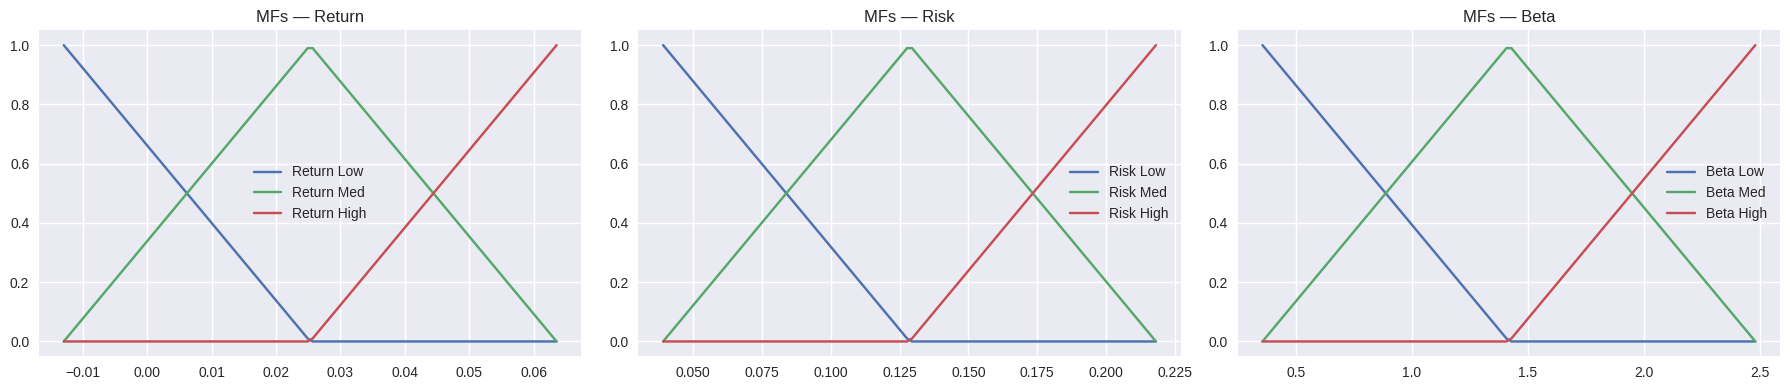

In [33]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))

# return
ax[0].plot(x_ret, ret_lo, label="Return Low")
ax[0].plot(x_ret, ret_md, label="Return Med")
ax[0].plot(x_ret, ret_hi, label="Return High")
ax[0].set_title("MFs — Return")
ax[0].legend()
ax[0].grid(True)

# risk
ax[1].plot(x_risk, risk_lo, label="Risk Low")
ax[1].plot(x_risk, risk_md, label="Risk Med")
ax[1].plot(x_risk, risk_hi, label="Risk High")
ax[1].set_title("MFs — Risk")
ax[1].legend()
ax[1].grid(True)

# beta
ax[2].plot(x_beta, beta_lo, label="Beta Low")
ax[2].plot(x_beta, beta_md, label="Beta Med")
ax[2].plot(x_beta, beta_hi, label="Beta High")
ax[2].set_title("MFs — Beta")
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()

 ## 8. Оптимізована 3-вхідна FIS (DE, PSO, SA)

In [34]:
# набір «скалярів» для оцінки рівнів (Low≈0.25, Med≈0.5, High≈0.75)
LEVEL_VALS = np.array([0.25, 0.50, 0.75])

# переводить одну змінну у скаляр через «centroid-of-levels».
def scalar_from_mfs(x, mfs, x_univ):
    μ = np.array([fuzz.interp_membership(x_univ, mf, x) for mf in mfs])
    if μ.sum() == 0:
        return 0.5
    return (μ @ LEVEL_VALS) / μ.sum()

In [35]:
# aдитивна 3-вхідна FIS без 27 правил
def manual_fis_3(ret, risk, beta, w_ret=1, w_risk=1, w_beta=1):
    # чіткий порядок MF: Low, Med, High
    ret_mfs3  = [ret_lo,  ret_md,  ret_hi]    # for Return
    risk_mfs3 = [risk_lo, risk_md, risk_hi]  # for Risk
    beta_mfs3 = [beta_lo, beta_md, beta_hi]  # for Beta

    # скаляризація кожного входу
    s_ret  = scalar_from_mfs(ret,  ret_mfs3,  x_ret)
    s_risk = scalar_from_mfs(risk, risk_mfs3, x_risk)
    s_beta = scalar_from_mfs(beta, beta_mfs3, x_beta)

    # зважене усереднення
    return (w_ret*s_ret + w_risk*s_risk + w_beta*s_beta) / (w_ret + w_risk + w_beta)

In [36]:
df["Score_manual_3"] = df.apply(
    lambda row: manual_fis_3(row.Return, row.Risk, row.Beta),
    axis=1
)

mae3 = mean_absolute_error(df["Sharpe"], df["Score_manual_3"])
mse3 = mean_squared_error(df["Sharpe"], df["Score_manual_3"])
rmse3 = np.sqrt(mse3)

print(f"3-вхідна FIS  →  MAE = {mae3:.4f} | RMSE = {rmse3:.4f}")

3-вхідна FIS  →  MAE = 0.1795 | RMSE = 0.1886


In [37]:
metrics_ext = pd.DataFrame({
    "MAE":  [mae_manual, mae3],
    "RMSE": [rmse_manual, rmse3]
}, index=["2-input FIS", "3-input FIS"])
metrics_ext

,MAE,RMSE
2-input FIS,0.110778,0.124109
3-input FIS,0.179506,0.188632


In [38]:
# оптимізаційні межі
bounds9 = ([(RET_MIN,  RET_MAX)]  * 3 +
           [(RISK_MIN, RISK_MAX)] * 3 +
           [(BETA_MIN, BETA_MAX)] * 3)

# обчислення оцінки
def compute_score3(chrom, r, s, b):
    r_pts, k_pts, b_pts = np.sort(chrom[:3]), np.sort(chrom[3:6]), np.sort(chrom[6:])
    r_mfs = make_triangles(r_pts, x_ret,  RET_MIN,  RET_MAX)
    k_mfs = make_triangles(k_pts, x_risk, RISK_MIN, RISK_MAX)
    b_mfs = make_triangles(b_pts, x_beta, BETA_MIN, BETA_MAX)

    s_r = np.array([scalar_from_mfs(val, r_mfs, x_ret) for val in r])
    s_k = np.array([scalar_from_mfs(val, k_mfs, x_risk) for val in s])
    s_b = np.array([scalar_from_mfs(val, b_mfs, x_beta) for val in b])

    return (s_r + s_k + s_b) / 3

# фітнес-функція: RMSE
def fitness3(chrom):
    sc = compute_score3(chrom, df["Return"].values,
                               df["Risk"].values,
                               df["Beta"].values)
    return np.sqrt(mean_squared_error(df["Sharpe"], sc))

In [39]:
# кількість повторів
N_RUNS = 1
base_seed = 42

In [40]:
def de(fitness_fn, bounds, max_iter=250, pop_size=15, F=0.5, CR=0.7, seed=42):

    bounds = np.array(bounds)
    dim = len(bounds)
    rng = np.random.default_rng(seed)

    t0 = time.perf_counter()

    # ініціалізація популяції
    pop = rng.uniform(bounds[:, 0], bounds[:, 1], size=(pop_size, dim))
    fitness = np.array([fitness_fn(ind) for ind in pop])
    de_hist = [fitness.min()]

    for gen in range(max_iter):
        for i in range(pop_size):
            idxs = np.delete(np.arange(pop_size), i)
            a, b, c = pop[rng.choice(idxs, 3, replace=False)]

            # мутація
            mutant = np.clip(a + F * (b - c), bounds[:, 0], bounds[:, 1])

            # кросовер
            cross_points = rng.random(dim) < CR
            if not np.any(cross_points):
                cross_points[rng.integers(0, dim)] = True
            trial = np.where(cross_points, mutant, pop[i])

            # відбір
            f_trial = fitness_fn(trial)
            if f_trial < fitness[i]:
                pop[i] = trial
                fitness[i] = f_trial

        de_hist.append(fitness.min())

    t_elapsed = time.perf_counter() - t0
    best_idx = np.argmin(fitness)
    best_sol = pop[best_idx]
    best_score = fitness[best_idx]

    return best_sol, best_score, de_hist, t_elapsed

In [41]:
de_runs = [de(fitness3, bounds9, seed=base_seed + i) for i in range(N_RUNS)]

best_de, best_fitness, de_hist, t_de = min(de_runs, key=lambda x: x[1])
score_de = compute_score3(best_de, df["Return"], df["Risk"], df["Beta"])

print(f"DE  (best of {N_RUNS}) → RMSE = {best_fitness:.4f}  time = {t_de:.2f}s")

DE  (best of 1) → RMSE = 0.0336  time = 10.94s


In [42]:
def pso(fitness_fn, bounds, n_par=20, iters=200, w=0.7, c1=1.4, c2=1.4, seed=None):
    import numpy as np
    import time

    rng = np.random.default_rng(seed)
    dim = len(bounds)
    lb, ub = np.array([b[0] for b in bounds]), np.array([b[1] for b in bounds])

    pos = rng.uniform(lb, ub, (n_par, dim))
    vel = np.zeros_like(pos)

    pbest = pos.copy()
    pbest_val = np.array([fitness_fn(p) for p in pos])
    gbest = pbest[pbest_val.argmin()].copy()

    pso_hist = [pbest_val.min()]
    t0 = time.perf_counter()

    for _ in range(iters):
        r1, r2 = rng.random((n_par, dim)), rng.random((n_par, dim))
        vel = w * vel + c1 * r1 * (pbest - pos) + c2 * r2 * (gbest - pos)
        pos = np.clip(pos + vel, lb, ub)

        vals = np.array([fitness_fn(p) for p in pos])
        mask = vals < pbest_val
        pbest[mask], pbest_val[mask] = pos[mask], vals[mask]
        gbest = pbest[pbest_val.argmin()].copy()
        pso_hist.append(pbest_val.min())

    t_elapsed = time.perf_counter() - t0
    return gbest, pbest_val.min(), pso_hist, t_elapsed

In [43]:
pso_runs = [pso(fitness3, bounds9, seed=base_seed + i) for i in range(N_RUNS)]

best_pso, best_val, pso_hist, t_pso = min(pso_runs, key=lambda x: x[1])
score_pso = compute_score3(best_pso, df["Return"], df["Risk"], df["Beta"])

print(f"PSO (best of {N_RUNS}) → RMSE = {best_val:.4f}  time = {t_pso:.2f}s")

PSO (best of 1) → RMSE = 0.0550  time = 10.69s


In [44]:
def sa(fitness, bounds, maxiter=500, T0=1.0, alpha=0.95, seed=None):
    dim = len(bounds)
    lb = np.array([b[0] for b in bounds])
    ub = np.array([b[1] for b in bounds])

    rng = np.random.default_rng(seed)
    curr = rng.uniform(lb, ub)
    curr_val = fitness(curr)
    best, best_val = curr.copy(), curr_val
    T = T0
    sa_hist = [curr_val]
    t0 = time.perf_counter()

    for _ in range(maxiter):
        step = rng.normal(scale=(ub - lb) * 0.1)   # <—
        next_ = np.clip(curr + step, lb, ub)
        next_val = fitness(next_)

        delta = next_val - curr_val
        if delta < 0 or rng.random() < np.exp(-delta / T):  # <—
            curr, curr_val = next_, next_val
            if curr_val < best_val:
                best, best_val = curr.copy(), curr_val

        sa_hist.append(best_val)
        T *= alpha  # охолодження

    t_sa = time.perf_counter() - t0
    return best, best_val, sa_hist, t_sa

In [45]:
sa_runs = [sa(fitness3, bounds9, maxiter=500, T0=1.0, alpha=0.95, seed=base_seed + i)
           for i in range(N_RUNS)]

best_sa, best_val_sa, sa_hist, t_sa = min(sa_runs, key=lambda x: x[1])
score_sa = compute_score3(best_sa, df["Return"], df["Risk"], df["Beta"])

print(f"SA  (best of {N_RUNS}) → RMSE = {best_val_sa:.4f}  time = {t_sa:.2f}s")

SA  (best of 1) → RMSE = 0.0355  time = 1.29s


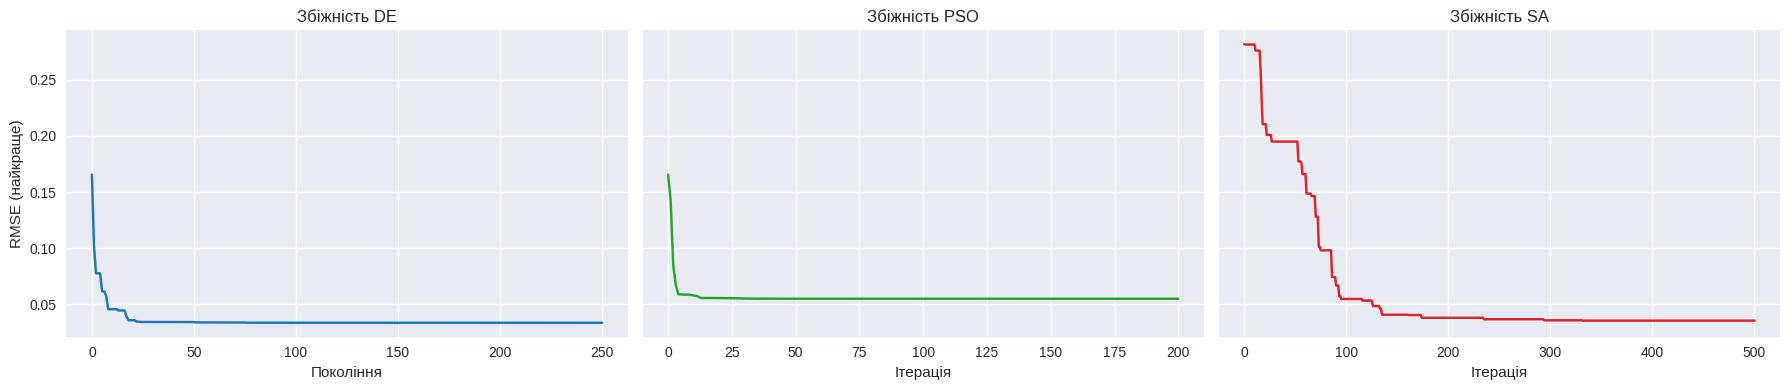

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

# DE
axes[0].plot(de_hist, color="tab:blue")
axes[0].set_title("Збіжність DE")
axes[0].set_xlabel("Покоління")
axes[0].set_ylabel("RMSE (найкраще)")
axes[0].grid(True)

# PSO
axes[1].plot(pso_hist, color="tab:green")
axes[1].set_title("Збіжність PSO")
axes[1].set_xlabel("Ітерація")
axes[1].grid(True)

# SA
axes[2].plot(sa_hist, color="tab:red")
axes[2].set_title("Збіжність SA")
axes[2].set_xlabel("Ітерація")
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [47]:
def metr(sc):
    return (mean_absolute_error(df["Sharpe"], sc),
            np.sqrt(mean_squared_error(df["Sharpe"], sc)),
            spearmanr(df["Sharpe"], sc).correlation)

m_de  = metr(score_de)
m_pso = metr(score_pso)
m_sa  = metr(score_sa)

metrics_all = pd.DataFrame({
    "MAE":  [m_de[0],  m_pso[0], m_sa[0]],
    "RMSE": [m_de[1],  m_pso[1], m_sa[1]],
    "ρ":    [m_de[2],  m_pso[2], m_sa[2]],
    "t, s": [t_de,     t_pso,    t_sa]
}, index=["DE", "PSO", "SA"])
metrics_all.style.format("{:.4f}")

,MAE,RMSE,ρ,"t, s"
DE,0.0207,0.0336,0.9264,10.9429
PSO,0.0436,0.0550,0.4323,10.6880
SA,0.0244,0.0355,0.8708,1.2885


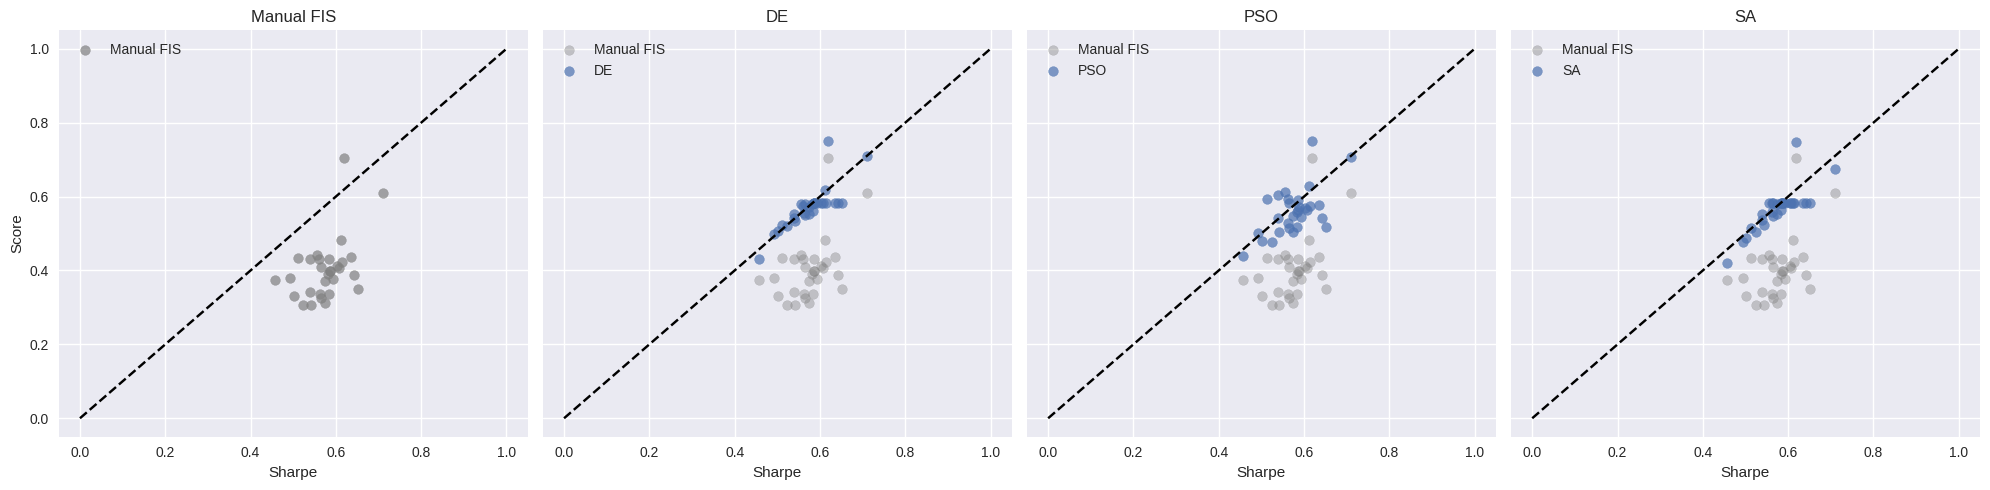

In [48]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=True)

# Manual FIS
axes[0].scatter(df["Sharpe"], df["Score_manual_3"], alpha=0.7, label="Manual FIS", color="grey")
axes[0].plot([0, 1], [0, 1], "--", color="black")
axes[0].set_title("Manual FIS")
axes[0].set_xlabel("Sharpe")
axes[0].set_ylabel("Score")
axes[0].legend()
axes[0].grid(True)

# DE
axes[1].scatter(df["Sharpe"], df["Score_manual_3"], alpha=0.4, label="Manual FIS", color="grey")
axes[1].scatter(df["Sharpe"], score_de, alpha=0.7, label="DE")
axes[1].plot([0, 1], [0, 1], "--", color="black")
axes[1].set_title("DE")
axes[1].set_xlabel("Sharpe")
axes[1].legend()
axes[1].grid(True)

# PSO
axes[2].scatter(df["Sharpe"], df["Score_manual_3"], alpha=0.4, label="Manual FIS", color="grey")
axes[2].scatter(df["Sharpe"], score_pso, alpha=0.7, label="PSO")
axes[2].plot([0, 1], [0, 1], "--", color="black")
axes[2].set_title("PSO")
axes[2].set_xlabel("Sharpe")
axes[2].legend()
axes[2].grid(True)

# SA
axes[3].scatter(df["Sharpe"], df["Score_manual_3"], alpha=0.4, label="Manual FIS", color="grey")
axes[3].scatter(df["Sharpe"], score_sa, alpha=0.7, label="SA")
axes[3].plot([0, 1], [0, 1], "--", color="black")
axes[3].set_title("SA")
axes[3].set_xlabel("Sharpe")
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

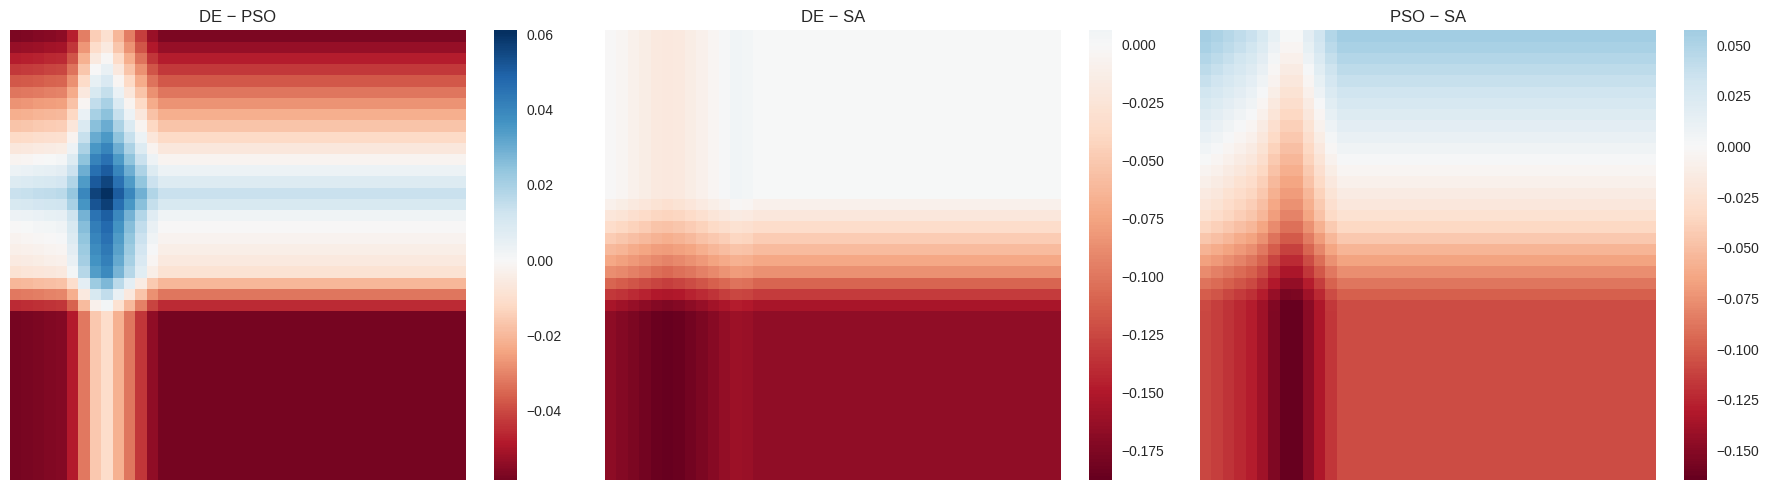

In [49]:
grid = 40
Rr, Rk = np.meshgrid(np.linspace(RET_MIN,  RET_MAX,  grid),
                     np.linspace(RISK_MIN, RISK_MAX, grid))
Rb = np.full_like(Rr, df["Beta"].median()).ravel()

Z_de  = compute_score3(best_de,  Rr.ravel(), Rk.ravel(), Rb)
Z_pso = compute_score3(best_pso, Rr.ravel(), Rk.ravel(), Rb)
Z_sa  = compute_score3(best_sa,  Rr.ravel(), Rk.ravel(), Rb)

diff_de_pso = (Z_pso - Z_de).reshape(grid, grid)
diff_de_sa  = (Z_sa  - Z_de).reshape(grid, grid)
diff_pso_sa = (Z_sa  - Z_pso).reshape(grid, grid)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 ряд, 3 графіки

sns.heatmap(diff_de_pso, ax=axes[0], cmap="RdBu", center=0,
            xticklabels=False, yticklabels=False)
axes[0].set_title("DE − PSO")

sns.heatmap(diff_de_sa, ax=axes[1], cmap="RdBu", center=0,
            xticklabels=False, yticklabels=False)
axes[1].set_title("DE − SA")

sns.heatmap(diff_pso_sa, ax=axes[2], cmap="RdBu", center=0,
            xticklabels=False, yticklabels=False)
axes[2].set_title("PSO − SA")

plt.tight_layout()
plt.show()

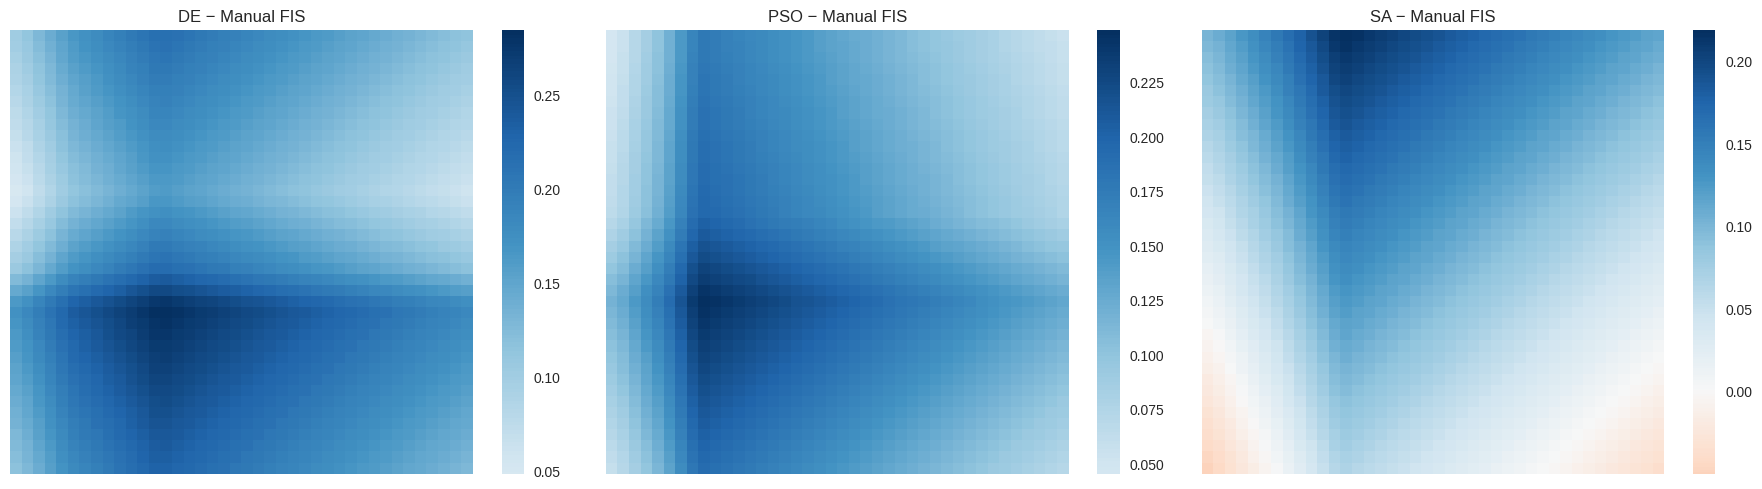

In [50]:
grid = 40
Rr, Rk = np.meshgrid(np.linspace(RET_MIN,  RET_MAX,  grid),
                     np.linspace(RISK_MIN, RISK_MAX, grid))
Rb = np.full_like(Rr, df["Beta"].median()).ravel()

Z_manual = np.array([
    manual_fis_3(r, k, b)
    for r, k, b in zip(Rr.ravel(), Rk.ravel(), Rb)
])

Z_de  = compute_score3(best_de,  Rr.ravel(), Rk.ravel(), Rb)
Z_pso = compute_score3(best_pso, Rr.ravel(), Rk.ravel(), Rb)
Z_sa  = compute_score3(best_sa,  Rr.ravel(), Rk.ravel(), Rb)

diff_de_manual  = (Z_de  - Z_manual).reshape(grid, grid)
diff_pso_manual = (Z_pso - Z_manual).reshape(grid, grid)
diff_sa_manual  = (Z_sa  - Z_manual).reshape(grid, grid)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.heatmap(diff_de_manual, ax=axes[0], cmap="RdBu", center=0,
            xticklabels=False, yticklabels=False)
axes[0].set_title("DE − Manual FIS")

sns.heatmap(diff_pso_manual, ax=axes[1], cmap="RdBu", center=0,
            xticklabels=False, yticklabels=False)
axes[1].set_title("PSO − Manual FIS")

sns.heatmap(diff_sa_manual, ax=axes[2], cmap="RdBu", center=0,
            xticklabels=False, yticklabels=False)
axes[2].set_title("SA − Manual FIS")

plt.tight_layout()
plt.show()

## 9. Інтерактивне демо з віджетами

In [51]:
ret_slider = wd.FloatSlider(value=float(df["Return"].median()),
                            min=float(RET_MIN), max=float(RET_MAX),
                            step=float((RET_MAX - RET_MIN) / 200), description="Return")

risk_slider = wd.FloatSlider(value=float(df["Risk"].median()),
                             min=float(RISK_MIN), max=float(RISK_MAX),
                             step=float((RISK_MAX - RISK_MIN) / 200), description="Risk")

beta_slider = wd.FloatSlider(value=float(df["Beta"].median()),
                             min=float(BETA_MIN), max=float(BETA_MAX),
                             step=float((BETA_MAX - BETA_MIN) / 200), description="Beta")

@wd.interact(ret=ret_slider, risk=risk_slider, beta=beta_slider)
def demo(ret, risk, beta):
    ret_arr = np.array([ret])
    risk_arr = np.array([risk])
    beta_arr = np.array([beta])

    manual_val = manual_fis_3(ret, risk, beta)

    opt_de  = compute_score3(best_de,  ret_arr, risk_arr, beta_arr)[0]
    opt_pso = compute_score3(best_pso, ret_arr, risk_arr, beta_arr)[0]
    opt_sa  = compute_score3(best_sa,  ret_arr, risk_arr, beta_arr)[0]

    print(f"Manual FIS     : {manual_val:.3f}")
    print(f"DE Optimized   : {opt_de:.3f}")
    print(f"PSO Optimized  : {opt_pso:.3f}")
    print(f"SA Optimized   : {opt_sa:.3f}")

interactive(children=(FloatSlider(value=0.01197569842699845, description='Return', max=0.060050090849455194, m…